# 응용데이터분석 Term Project#1 
## 소프트웨어융합학과 2020105705 박현준
---

# 주제: 더 정확한 피싱 사이트 예측을 위한 feature 분석 및 피싱 사이트의 특징 파악

- 인터넷의 발전과 함께 디지털 기술은 우리의 일상 생활에 깊숙이 자리 잡았다. 온라인 쇼핑, 인터넷 뱅킹, 소셜 미디어 등 다양한 온라인 서비스가 편리함을 제공하는 반면, 사이버 보안 위협도 그만큼 증가하고 있습니다. 특히 피싱 사이트는 사용자 정보를 탈취하고 사기를 치는 데 사용되는 주요 수단으로, 개인 정보가 갈수록 중요해지는 만큼 이에 대한 효과적인 대응이 요구되고 있습니다. 
- 최근 네이버를 사칭한 피싱 사이트가 발견되어 이용자의 각별한 주의가 필요하였다. 이것으로 보아 피싱 사이트의 범위 및 피해가 늘어나고 있으며 더 신속하고 정확한 예측 및 조치가 필요하다.
- 최신 피싱 사이트의 예측을 개선하기 위해 과거 피싱 사이트에서 사용된 feature중 유효한 특성을 분석하고, 정상 사이트와 피싱 사이트 간의 유의미한 차이를 찾아내는 방법을 제안한다. 또한, 피싱 사이트의 주된 타겟이 되는 특정 유형의 사이트를 식별하여, 예방 및 보안을 향상시키는 전략을 고안한다.

# 가설
### 1. 기존 피싱 사이트 예측에 사용된 feature들 중 현재 피싱 사이트 예측에 유효한 feature들이 있다.
### 2. 정상 사이트와 최신 피싱 사이트에 나타나는 HTML tag&JavaScript code에 유의미한 차이가 있다. 그 feature를 사용하면 Accuracy가 올라갈 것이다.
### 3. 피싱 사이트의 타겟이 되는 일부 유형의 사이트가 있다. 
---

# 가설 1. 기존 피싱 사이트 예측에 사용된 feature들 중 현재 피싱 사이트 예측에 유효한 feature들이 있다.

## Data Preprocessing
* 최신 피싱 사이트를 데이터로 사용하여 실시간으로 사이트가 차단당하고 있어 html tag, text가 크롤링이 안될 수 있습니다.
* 사용하였던 피싱 사이트, 정상 사이트 파일로 첨부하겠습니다.
---
* 데이터는 정상적인 웹 사이트 500개와 phishing 웹 사이트 500개를 준비하였다
* 최신 피싱 사이트를 예측하는 것이 목적이기 때문에 가장 최신에 올라온 피싱 사이트 500개를 추출하였다.
* 정상 웹 사이트는 한국에서 방문 빈도가 높은 순위로 40개의 기본 도메인 url에서 더 세분화해서 들어갔을 때 url 25개씩 총 500개를 준비하였다. 

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from urllib.parse import urlparse, urljoin
import ssl
import OpenSSL
import socket
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# 데이터 불러오기 
normal_df = pd.read_csv('sampled_normal_urls.csv')
phishing_df = pd.read_csv('sampled_phishing_urls.csv')

In [9]:
#normal_df 출력
print(normal_df)

                                                   URL
0    https://www.chosun.com/entertainments/broadcas...
1    https://www.chosun.com/national/national_gener...
2    https://www.inven.co.kr/webzine/news/?news=295...
3                         https://www.arca.live#bottom
4             https://www.youtube.com/about/copyright/
..                                                 ...
495                     https://www.youtube.com/about/
496             https://www.tistory.com/skin/pg_Poster
497  https://www.donga.com/news/Society/article/all...
498  https://www.etoland.co.kr/bbs/hit.php?bn_id=92...
499  https://www.etoland.co.kr/plugin/social_login/...

[500 rows x 1 columns]


In [10]:
#phishing_df 출력
print(phishing_df)

                                                  URL
0                        https://hlgtde.hiplimit.top/
1                               https://kl7777cp.com/
2              https://lh14.pages.dev/appeal_case_ID/
3               https://check-valuation-r.vercel.app/
4              https://uch.mrn.mybluehost.me/MS/DHLM/
..                                                ...
495                           https://huateapalt.com/
496                           https://lxinfotech.com/
497                           https://xixiwallet.com/
498  http://friendly-melomakarona-d221cc.netlify.app/
499   https://blog.toolsxsocial.in/ff-gems/3bX363K667

[500 rows x 1 columns]


In [13]:
# 데이터에서 URL column만 가지고 와서 합치기
df1 = normal_df.iloc[:,0]
df2 = phishing_df.iloc[:,0]
combined_urls = pd.concat([df1, df2]).reset_index(drop=True)
df = pd.DataFrame(combined_urls, columns=['URL'])

# 합친 데이터프레임에서 타겟 변수 넣기. (정상 사이트: 0, 피싱 사이트: 1)
df['phishing'] = 0
df.loc[500:999, 'phishing'] = 1

## 다음은 기존 피싱 사이트 예측에 사용된 feature들을 column들에 추가하는 코드이다.

### 참고 문헌을 통해 URL 기반 피싱 예측할 때 사용할 Feature
#### 여기서 feature들을 0과 1로 사용하는 것이 아닌 수치형 변수로 나올 수 있는 값은 큰 값과 작은 값의 차이를 주기 위해  수치형 그대로 두었다.
<br>![nn](phishing_feature.png)

In [14]:
# 도메인 시작 부분에 ip 주소가 있는가? 없으면 0, 있으면 1
def is_ip_in_url(url):
    ip_pattern = re.compile(r'^(http://|https://)?(\d{1,3}\.){3}\d{1,3}(/|$)')
    
    return bool(ip_pattern.search(url))

df['has_ip'] = df['URL'].apply(lambda x: 1 if is_ip_in_url(x) else 0)
print(df[df['has_ip']==1])
df

Empty DataFrame
Columns: [URL, phishing, has_ip]
Index: []


,URL,phishing,has_ip
0,https://www.chosun.com/entertainments/broadcas...,0,0
1,https://www.chosun.com/national/national_gener...,0,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0
3,https://www.arca.live#bottom,0,0
4,https://www.youtube.com/about/copyright/,0,0
...,...,...,...
995,https://huateapalt.com/,1,0
996,https://lxinfotech.com/,1,0
997,https://xixiwallet.com/,1,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0


In [15]:
#URL이 길면 phishing 사이트일 확률이 높다 (url_length는 어떤 기준으로 0과 1로 나누는 것이 아닌 그대로 사용)
df['url_length'] = df['URL'].apply(len)
df

,URL,phishing,has_ip,url_length
0,https://www.chosun.com/entertainments/broadcas...,0,0,86
1,https://www.chosun.com/national/national_gener...,0,0,87
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66
3,https://www.arca.live#bottom,0,0,28
4,https://www.youtube.com/about/copyright/,0,0,40
...,...,...,...,...
995,https://huateapalt.com/,1,0,23
996,https://lxinfotech.com/,1,0,23
997,https://xixiwallet.com/,1,0,23
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48


In [16]:
# url 단축 서비스를 사용한 url은 도메인을 다음 나타나는 도메인 목록이 나타날 확률이 높기 때문에 다음과 같은 방법으로 검출한다.
# 단축 서비스 사용시 1, 아니면 0

# 대표 URL 단축 서비스 도메인 목록. 모든 단축 서비스 목록을 추가할 수 없다는 한계점 존재
short_url_domains = [
    "bit.ly",
    "tinyurl.com",
    "is.gd",
    "t.co",
    "goo.gl",
    "ow.ly",
    "t2mio.com",
    "buff.ly",
    "adf.ly",
    "bit.do",
    "cutt.ly",
    "mcaf.ee",
    "rebrand.ly",
    "soo.gd",
    "s2r.co",
    "qr.ae",
    "v.gd"
]

def is_shortened_url(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return 1 if domain in short_url_domains else 0

df['is_shortened'] = df['URL'].apply(is_shortened_url)
print(df[df['is_shortened']==1])
df

Empty DataFrame
Columns: [URL, phishing, has_ip, url_length, is_shortened]
Index: []


,URL,phishing,has_ip,url_length,is_shortened
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0
3,https://www.arca.live#bottom,0,0,28,0
4,https://www.youtube.com/about/copyright/,0,0,40,0
...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0
996,https://lxinfotech.com/,1,0,23,0
997,https://xixiwallet.com/,1,0,23,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0


In [17]:
# URL에 '@' 문자가 포함되어 있는지 확인하는 함수(포함하면 1, 아니면 0)
def contains_at_symbol(url):
    return 1 if '@' in url else 0

df['contains_@'] = df['URL'].apply(contains_at_symbol)
print(df[df['contains_@']==1])
df

Empty DataFrame
Columns: [URL, phishing, has_ip, url_length, is_shortened, contains_@]
Index: []


,URL,phishing,has_ip,url_length,is_shortened,contains_@
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0
3,https://www.arca.live#bottom,0,0,28,0,0
4,https://www.youtube.com/about/copyright/,0,0,40,0,0
...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0
996,https://lxinfotech.com/,1,0,23,0,0
997,https://xixiwallet.com/,1,0,23,0,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0


In [18]:
# redirecting을 확인하기 위해 domain 이름 뒤 double_slash의 유무 판단(있으면 1, 없으면 0)
def check_double_slash_position(url):
    parsed_url = urlparse(url)
    path = parsed_url.path

    if url.startswith("http://"):
        # "http://"로 시작하면 "//"는 URL 전체에서 7번째 위치에 있어야 함
        # "http://"는 7글자이므로, 전체 URL에서 7번째 위치는 6번째 인덱스
        return 1 if path.startswith("//") and url.index(path) == 7 else 0
    elif url.startswith("https://"):
        # "https://"로 시작하면 "//"는 URL 전체에서 8번째 위치에 있어야 함
        # "https://"는 8글자이므로, 전체 URL에서 8번째 위치는 7번째 인덱스
        return 1 if path.startswith("//") and url.index(path) == 8 else 0
    else:
        # "http://" 또는 "https://"로 시작하지 않는 경우
        return 0
    
df['valid_double_slash'] = df['URL'].apply(check_double_slash_position)
print(df[df['valid_double_slash']==1])
df

Empty DataFrame
Columns: [URL, phishing, has_ip, url_length, is_shortened, contains_@, valid_double_slash]
Index: []


,URL,phishing,has_ip,url_length,is_shortened,contains_@,valid_double_slash
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0,0
3,https://www.arca.live#bottom,0,0,28,0,0,0
4,https://www.youtube.com/about/copyright/,0,0,40,0,0,0
...,...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0,0
996,https://lxinfotech.com/,1,0,23,0,0,0
997,https://xixiwallet.com/,1,0,23,0,0,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0,0


In [19]:
# URL에 '-' 문자가 포함되어 있는지 확인하는 함수(포함하면 1, 아니면 0)
def contains_dash(url):
    return 1 if '-' in url else 0

df['contains_dash'] = df['URL'].apply(contains_dash)
print(df[df['contains_dash']==1])
df

                                                   URL  phishing  has_ip  \
17   https://www.gmarket.co.kr#skip-navigation-cont...         0       0   
28   https://customerservice.aliexpress.com/categor...         0       0   
63   https://www.asianhd2.cc/videos/the-journey-to-...         0       0   
92   https://www.chosun.com/sports/world-football/2...         0       0   
94   https://www.asianhd2.cc/videos/reblooming-blue...         0       0   
..                                                 ...       ...     ...   
980  https://remove-your-fb-account-see-why.vercel....         1       0   
983        https://unique-hippopotamus.static.domains/         1       0   
984  https://remove-your-fb-account-see-why.vercel....         1       0   
998   http://friendly-melomakarona-d221cc.netlify.app/         1       0   
999    https://blog.toolsxsocial.in/ff-gems/3bX363K667         1       0   

     url_length  is_shortened  contains_@  valid_double_slash  contains_dash  
17      

,URL,phishing,has_ip,url_length,is_shortened,contains_@,valid_double_slash,contains_dash
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0,0,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0,0,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0,0,0
3,https://www.arca.live#bottom,0,0,28,0,0,0,0
4,https://www.youtube.com/about/copyright/,0,0,40,0,0,0,0
...,...,...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0,0,0
996,https://lxinfotech.com/,1,0,23,0,0,0,0
997,https://xixiwallet.com/,1,0,23,0,0,0,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0,0,1


In [20]:
#subdomain의 개수를 확인하기 위해 .의 개수를 추가. 
def classify_url(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    
    if domain.startswith('www.'):
        domain = domain[4:]
    
    # 피싱의 경우 한국 사이트가 아닐 경우 대비. 
    ccTLDs = ['.uk', '.jp', '.kr', '.de', '.fr', '.cn', '.us', '.au', '.ca']
    for ccTLD in ccTLDs:
        if domain.endswith(ccTLD):
            domain = domain[:-(len(ccTLD))]
            break
            
    dot_count = domain.count('.')
    
    # 본 논문에서는 2개 이상이면 피싱 사이트로 분류하였지만 하위 도메인이 많을 수록 피싱 사이트일 확률에 영향을 미친다고 판단하여 가중치를 주기 위해 count 사용
    return dot_count
df['subdomain'] = df['URL'].apply(classify_url)
df

,URL,phishing,has_ip,url_length,is_shortened,contains_@,valid_double_slash,contains_dash,subdomain
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0,0,0,1
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0,0,0,1
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0,0,0,1
3,https://www.arca.live#bottom,0,0,28,0,0,0,0,1
4,https://www.youtube.com/about/copyright/,0,0,40,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0,0,0,1
996,https://lxinfotech.com/,1,0,23,0,0,0,0,1
997,https://xixiwallet.com/,1,0,23,0,0,0,0,1
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0,0,1,2


In [23]:
# 인증서 기간이 기준치 이상이면 0, 아니면 1
#사이트들의 인증 기관과 인증서 기간을 확인
# 모든 인증 기관을 추가할 수 없다는 한계점 존재
# Google trust service는 인증서 기간을 1.5개월로 확 줄인 것을 알 수 있어 따로 처리하기로 하였다.

trusted_issuers = [
    "GeoTrust", "GoDaddy", "Network Solutions", "Thawte", "Comodo", "Doster", "VeriSign",
    "DigiCert", "Let's Encrypt", "Sectigo", "Entrust", "GlobalSign", "Amazon", "Google Trust Services"
]

def get_certificate_info(domain):
    try:
        ctx = ssl.create_default_context()
        s = ctx.wrap_socket(socket.socket(), server_hostname=domain)
        s.settimeout(5.0)
        s.connect((domain, 443))

        cert = s.getpeercert(True)
        x509 = OpenSSL.crypto.load_certificate(OpenSSL.crypto.FILETYPE_ASN1, cert)
        
        issuer = x509.get_issuer()
        issuer_common_name = dict(issuer.get_components()).get(b'O', b'').decode('utf-8')

        not_before = datetime.strptime(x509.get_notBefore().decode('ascii'), '%Y%m%d%H%M%SZ')
        not_after = datetime.strptime(x509.get_notAfter().decode('ascii'), '%Y%m%d%H%M%SZ')
        
        cert_validity_days = (not_after - not_before).days
        cert_validity_months = cert_validity_days / 30

        return issuer_common_name, cert_validity_months

    except Exception as e:
        return None, None

def certificated(url):
    parsed_url = urlparse(url)
    if parsed_url.scheme != 'https':
        return 1  

    domain = parsed_url.netloc
    issuer, cert_validity_months = get_certificate_info(domain)
    
    if issuer is None:
        return 1  
    
    if issuer == "Google Trust Services" and cert_validity_months >= 1.5:
        return 0  
    elif any(trusted in issuer for trusted in trusted_issuers) and cert_validity_months >= 12:
        return 0 
    else:
        return 1  

df['certificated'] = df['URL'].apply(certificated)
print(df[df['certificated']==1])

                                                   URL  phishing  has_ip  \
0    https://www.chosun.com/entertainments/broadcas...         0       0   
1    https://www.chosun.com/national/national_gener...         0       0   
3                         https://www.arca.live#bottom         0       0   
4             https://www.youtube.com/about/copyright/         0       0   
8          https://maps.google.co.kr/maps?hl=ko&tab=wl         0       0   
..                                                 ...       ...     ...   
995                            https://huateapalt.com/         1       0   
996                            https://lxinfotech.com/         1       0   
997                            https://xixiwallet.com/         1       0   
998   http://friendly-melomakarona-d221cc.netlify.app/         1       0   
999    https://blog.toolsxsocial.in/ff-gems/3bX363K667         1       0   

     url_length  is_shortened  contains_@  valid_double_slash  contains_dash  \
0      

In [24]:
#해당 url이 외부 사이트의 favicon을 가져왔는지 유무
def is_favicon_phishing(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        

        parsed_url = urlparse(url)
        base_domain = parsed_url.netloc
        
        favicon_url = None
        icon_link = soup.find("link", rel=lambda x: x and 'icon' in x.lower())
        if icon_link:
            favicon_url = icon_link['href']
            if not favicon_url.startswith(('http://', 'https://')):
                favicon_url = urljoin(url, favicon_url)
        
        if favicon_url:
            favicon_parsed_url = urlparse(favicon_url)
            favicon_domain = favicon_parsed_url.netloc
            if favicon_domain and favicon_domain != base_domain:
                return 1  
        return 0  
    except Exception as e:
        print(f"Error checking favicon for {url}: {e}")
        return 1 

df['favicon'] = df['URL'].apply(is_favicon_phishing)

Error checking favicon for https://www.ssg.com/item/itemView.ssg?itemId=1000527396910&siteNo=7008&salestrNo=6005: 401 Client Error:  for url: https://www.ssg.com/item/itemView.ssg?itemId=1000527396910&siteNo=7008&salestrNo=6005
Error checking favicon for https://www.newspic.kr/main?category=hot: 404 Client Error: Not Found for url: https://www.newspic.kr/main?category=hot
Error checking favicon for https://www.ssg.com/item/itemView.ssg?itemId=1000595658054&siteNo=7015&salestrNo=6005: 401 Client Error:  for url: https://www.ssg.com/item/itemView.ssg?itemId=1000595658054&siteNo=7015&salestrNo=6005
Error checking favicon for https://www.ssg.com/search.ssg?target=all&query=옥수수&src_area=main: 401 Client Error:  for url: https://www.ssg.com/search.ssg?target=all&query=%EC%98%A5%EC%88%98%EC%88%98&src_area=main
Error checking favicon for https://www.meta.com/quest/: 429 Client Error: Too Many Requests for url: https://www.meta.com/quest/
Error checking favicon for https://help.adbrix.io/hc/ko:

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Error checking favicon for https://www.ssg.com/item/itemView.ssg?itemId=2097001752975&siteNo=6001&salestrNo=2569: 401 Client Error:  for url: https://www.ssg.com/item/itemView.ssg?itemId=2097001752975&siteNo=6001&salestrNo=2569
Error checking favicon for https://www.ssg.com/search.ssg?target=all&query=%eb%89%b4%eb%b0%9c%eb%9e%80%ec%8a%a4%ec%9a%b4%eb%8f%99%ed%99%94&src_area=item_list: 401 Client Error:  for url: https://www.ssg.com/search.ssg?target=all&query=%EB%89%B4%EB%B0%9C%EB%9E%80%EC%8A%A4%EC%9A%B4%EB%8F%99%ED%99%94&src_area=item_list
Error checking favicon for https://www.ssg.com/item/itemView.ssg?itemId=1000025929508&siteNo=7011&salestrNo=6005: 401 Client Error:  for url: https://www.ssg.com/item/itemView.ssg?itemId=1000025929508&siteNo=7011&salestrNo=6005
Error checking favicon for https://www.newspic.kr/main?category=CA03: 404 Client Error: Not Found for url: https://www.newspic.kr/main?category=CA03
Error checking favicon for https://www.ssg.com/item/itemView.ssg?itemId=20970

Error checking favicon for https://production.discoveronline.discoverloginacces.workers.dev/: HTTPSConnectionPool(host='production.discoveronline.discoverloginacces.workers.dev', port=443): Read timed out. (read timeout=10)
Error checking favicon for https://confirmcs2.org/workshop: HTTPSConnectionPool(host='confirmcs2.org', port=443): Max retries exceeded with url: /workshop (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001396E804950>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error checking favicon for https://7360941234960790399191467.hanefra7bikiemta.com/: 406 Client Error: Not Acceptable for url: https://7360941234960790399191467.hanefra7bikiemta.com/
Error checking favicon for https://leightonpetroleum.com/: HTTPSConnectionPool(host='leightonpetroleum.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certi

In [25]:
df

,URL,phishing,has_ip,url_length,is_shortened,contains_@,valid_double_slash,contains_dash,subdomain,certificated,favicon
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0,0,0,1,1,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0,0,0,1,1,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0,0,0,1,0,1
3,https://www.arca.live#bottom,0,0,28,0,0,0,0,1,1,0
4,https://www.youtube.com/about/copyright/,0,0,40,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0,0,0,1,1,1
996,https://lxinfotech.com/,1,0,23,0,0,0,0,1,1,1
997,https://xixiwallet.com/,1,0,23,0,0,0,0,1,1,1
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0,0,1,2,1,1


In [27]:
# 중요한 포트와 그들의 open 상태 확인
# 다음 port를 만족하면 0, 아니면 1
preferred_ports = {
    21: "Close",
    22: "Close",
    23: "Close",
    80: "Open",
    443: "Open",
    445: "Close",
    1433: "Close",
    1521: "Close",
    3306: "Close",
    3389: "Close"
}

def classify_by_port(url):
    parsed_url = urlparse(url)
    port = parsed_url.port
    if port is None:
        port = 443 if parsed_url.scheme == 'https' else 80  # 기본 포트 설정
    
    preferred_status = preferred_ports.get(port, None)
    
    if preferred_status is None:
        return 0  # 포트가 선호 상태 목록에 없으면 합법적인 것으로 간주
    elif preferred_status == "Close":
        return 1  # 포트가 닫혀야 하는 상태인데 열려 있으면 피싱
    else:
        return 0  # 포트가 열려야 하는 상태인데 열려 있으면 합법적인 것으로 간주

df['port_status'] = df['URL'].apply(classify_by_port)
df

,URL,phishing,has_ip,url_length,is_shortened,contains_@,valid_double_slash,contains_dash,subdomain,certificated,favicon,port_status
0,https://www.chosun.com/entertainments/broadcas...,0,0,86,0,0,0,0,1,1,0,0
1,https://www.chosun.com/national/national_gener...,0,0,87,0,0,0,0,1,1,0,0
2,https://www.inven.co.kr/webzine/news/?news=295...,0,0,66,0,0,0,0,1,0,1,0
3,https://www.arca.live#bottom,0,0,28,0,0,0,0,1,1,0,0
4,https://www.youtube.com/about/copyright/,0,0,40,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://huateapalt.com/,1,0,23,0,0,0,0,1,1,1,0
996,https://lxinfotech.com/,1,0,23,0,0,0,0,1,1,1,0
997,https://xixiwallet.com/,1,0,23,0,0,0,0,1,1,1,0
998,http://friendly-melomakarona-d221cc.netlify.app/,1,0,48,0,0,0,1,2,1,1,0


## 회귀에 사용할 최종 데이터 프레임을 완성하였다. 다음 feature들을 사용해 회귀 모델을 만들어 본다.

In [28]:
# train, test 분할
X_train, X_test, y_train, y_test = train_test_split(df[['has_ip','url_length','is_shortened','contains_@','valid_double_slash','contains_dash','subdomain','certificated','favicon','port_status']],df['phishing'], test_size=0.2)
print(X_train,'\n',y_train)

     has_ip  url_length  is_shortened  contains_@  valid_double_slash  \
295       0          56             0           0                   0   
108       0          54             0           0                   0   
45        0          27             0           0                   0   
71        0          63             0           0                   0   
981       0          51             0           0                   0   
..      ...         ...           ...         ...                 ...   
303       0          62             0           0                   0   
613       0          21             0           0                   0   
11        0          65             0           0                   0   
365       0          37             0           0                   0   
838       0          33             0           0                   0   

     contains_dash  subdomain  certificated  favicon  port_status  
295              0          2             0        0   

### Data Preparation 과정에서 최신 피싱 사이트와 정상 사이트가 모두 같은 값으로 나타나는 feature들이 존재하였다. 
### 위와 같은 결과가 나온 이유에 대해 다음과 같은 가설을 내렸다.
### 1. 데이터셋이 부족하여 편향적인 데이터 셋을 샘플링 하였다.
### 2. 최신 피싱 사이트는 몇몇의 단순 URL 특징에 걸리지 않는다. 
### 따라서, 다음 모델들을 사용한다.
### 1. L1-norm을 사용하여 feature selection을 통한 Logistic regression 
### 2. random하게 feature를 사용할 수 있도록 randomforest model을 사용한다.
### 3.  이 두 모델을 votingClassifer를 통해 투표를 받는다(classifier 2개를 사용하기 때문에 soft voting 방식을 사용하여 확률이 더 높은 것을 채택)

### LogisticRegression with L1-norm

In [30]:
from sklearn.linear_model import LogisticRegression

# default solver인 lbfgs는 l1 norm을 지원하지 않아 l1 norm을 지원하고 작은 데이터셋에 적합한 liblinear 사용
model_LR = LogisticRegression(penalty='l1', solver='liblinear')
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

print("My prediction:", y_pred)
print("Actual values:", y_test.values)
print("Accuracy:", model_LR.score(X_test, y_test))

My prediction: [1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1
 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0
 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0
 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0]
Actual values: [0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0
 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0]
Accuracy: 0.815


In [33]:
# 각 샘플에 대한 클래스 확률 출력
probabilities = model_LR.predict_proba(X_test)

prob_df = pd.DataFrame(probabilities, columns=model_LR.classes_)
prob_df['Predicted'] = y_pred
prob_df['Actual'] = y_test.values
print(prob_df)

            0         1  Predicted  Actual
0    0.263782  0.736218          1       0
1    0.602276  0.397724          0       1
2    0.923771  0.076229          0       0
3    0.024282  0.975718          1       1
4    0.901654  0.098346          0       0
..        ...       ...        ...     ...
195  0.107570  0.892430          1       1
196  0.019555  0.980445          1       1
197  0.180039  0.819961          1       0
198  0.022983  0.977017          1       1
199  0.732859  0.267141          0       0

[200 rows x 4 columns]


              Feature  Coefficient
0              has_ip     0.000000
1          url_length    -0.033012
2        is_shortened     0.000000
3          contains_@     0.000000
4  valid_double_slash     0.000000
5       contains_dash     2.563774
6           subdomain     1.841730
7        certificated     2.213811
8             favicon     0.122320
9         port_status     0.000000
절편(상수항): -3.6782043648806075


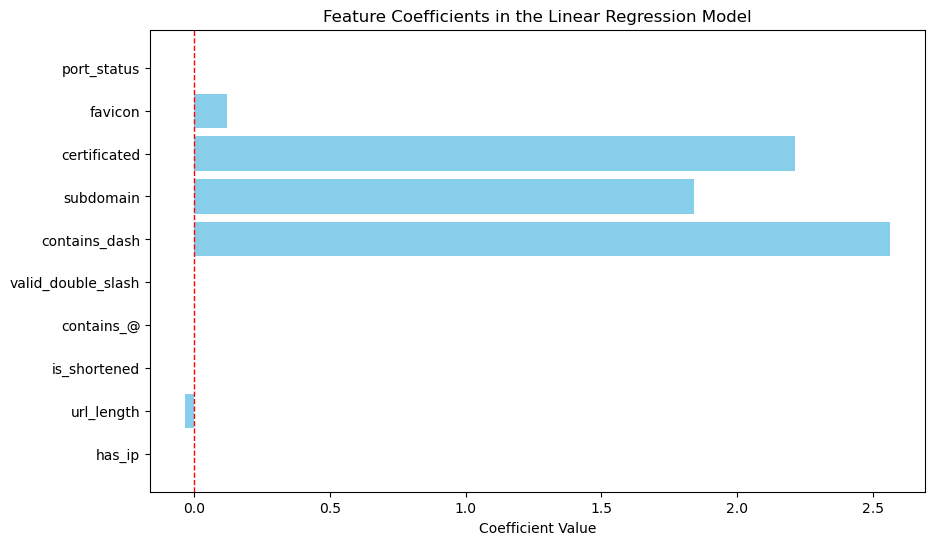

In [94]:
# 사용한 독립변수의 계수를 보기 
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_LR.coef_[0]
})
print(coefficients)

print("절편(상수항):", model_LR.intercept_[0])
# 계수를 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients in the Linear Regression Model')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.show()

### RandomForest

In [35]:
from sklearn.ensemble import RandomForestClassifier
#overfitting을 막기 위해 min_samples_split 적용
model_RF = RandomForestClassifier(min_samples_split = 5)
model_RF.fit(X_train,y_train)
y_pred = model_RF.predict(X_test)
train_pred = model_RF.predict(X_train)

print("My prediction:", y_pred)
print("Actual values:", y_test.values)
print("Test Accuracy:", model_RF.score(X_test, y_test))
print("-------------------------------------")
print(train_pred)
print(y_train.values)
print("Train Accuracy:", model_RF.score(X_train, y_train))

My prediction: [0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0
 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0]
Actual values: [0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0
 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0]
Test Accuracy: 0.835
-------------------------------------
[0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0
 1 1 0 0 1 1 1 1 0 0 0

In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

clf1 = model_LR
clf2 = model_RF
#soft voting 
voting_clf = VotingClassifier(
    estimators=[('log_reg', clf1), ('ran_fst', clf2)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

print("Accuracy", accuracy_score(y_test.values, y_pred))
print("F1-score", f1_score(y_test.values, y_pred))

proba_log_reg = voting_clf.named_estimators_['log_reg'].predict_proba(X_test)
print(proba_log_reg)
proba_ran_fst = voting_clf.named_estimators_['ran_fst'].predict_proba(X_test)
print(proba_ran_fst)

Accuracy 0.88
F1-score 0.8878504672897196
[[0.26378087 0.73621913]
 [0.60225304 0.39774696]
 [0.92378553 0.07621447]
 [0.02427862 0.97572138]
 [0.90171709 0.09828291]
 [0.27680307 0.72319693]
 [0.60225304 0.39774696]
 [0.20410174 0.79589826]
 [0.06450518 0.93549482]
 [0.18348378 0.81651622]
 [0.62802029 0.37197971]
 [0.2530101  0.7469899 ]
 [0.93531721 0.06468279]
 [0.83957451 0.16042549]
 [0.94339438 0.05660562]
 [0.66764979 0.33235021]
 [0.6257232  0.3742768 ]
 [0.96830545 0.03169455]
 [0.99210412 0.00789588]
 [0.022982   0.977018  ]
 [0.55397883 0.44602117]
 [0.79776001 0.20223999]
 [0.23398452 0.76601548]
 [0.00602312 0.99397688]
 [0.22811876 0.77188124]
 [0.05209554 0.94790446]
 [0.00984542 0.99015458]
 [0.02944114 0.97055886]
 [0.95955958 0.04044042]
 [0.61795932 0.38204068]
 [0.24602732 0.75397268]
 [0.02787667 0.97212333]
 [0.00733302 0.99266698]
 [0.01769621 0.98230379]
 [0.47347262 0.52652738]
 [0.58633329 0.41366671]
 [0.58633329 0.41366671]
 [0.01121985 0.98878015]
 [0.5240

## 1. soft voting classifier model의 test-accuracy가 0.88이 나왔다. 
## 2. 기본 URL 특징을 사용해서도 88%의 성능을 보여주었다. 
## 3. url_length, contains_dash, subdomain, certificated, favicon이 의미있는 feature로 보인다. 나머지 feature는 분류 시 사용되지 않는다. 
<br>


<span style="color:red; font-size:24px;">결론: 최신 피싱 사이트 예측에 이전의 피싱 사이트 예측 시 사용했던 feature들 중 유효한 feature가 존재하고 정확성도 준수하다.</span>
<br>

<span style="color:blue; font-size:24px;">활용 방안 1. 크롬 익스텐션에서 가볍고 빠르게 돌아가기 위해 모든 feature를 사용하지 않고 5개의 feature를 중점적으로 사용하여 서비스를 제공한다.</span>
---

 # 가설2. 정상 웹사이트에 나타나지 않고 피싱 웹사이트에만 나타나는 HTML tag&JavaScript code가 있을 것이다. 그러한 feature가 존재한다면 기존의 feature와 같이 학습시켜 더 정확한 결과를 도출할 수 있다.

### *여기서는 500개를 다 사용하기에 데이터 양이 너무 많아 정상 사이트 40개 피싱 사이트 40개로 진행하였다.

In [38]:
normal_df_2 = pd.read_csv('final_normal.csv')
phishing_df_2 = pd.read_csv('final_phishing.csv')

In [39]:
normal_df_2

,URL,HTML Code,JavaScript Code
0,https://www.youtube.com,"<!DOCTYPE html>\n<html darker-dark-theme="""" da...","window.WIZ_global_data = {""MuJWjd"":false,""nQyA..."
1,https://www.google.com,"<!DOCTYPE html>\n<html itemscope="""" itemtype=""...",(function(){var _g={kEI:'6bVQZsKUL6_p1e8PleKFk...
2,https://www.naver.com,"<!DOCTYPE html>\n<html class=""fzoom"" lang=""ko""...","window.gladsdk=window.gladsdk||{},window.glads..."
3,https://www.fmkorea.com,"<!DOCTYPE html>\n<html lang=""ko"">\n <head>\n ...","\n//<![CDATA[\n\t\tvar current_url = ""/"";\n\t..."
4,https://www.daum.net,"<!DOCTYPE html>\n<html lang=""ko"">\n <head>\n ...","\nwindow.tiller = { ""serverTime"": 171656549473..."
5,https://www.kakao.com,"<!DOCTYPE html>\n<html data-n-head=""%7B%22lang...","!function(e,t,n,c,o,a,f){e.fbq||(o=e.fbq=funct..."
6,https://www.arca.live,"<!DOCTYPE html>\n<html class=""width-1300 navba...","window.LiveConfig={""country"":null,""domain"":""ar..."
7,https://www.twitter.com,<!DOCTYPE html>\n<head>\n <title>\n x.com\n <...,"document.location = ""https://twitter.com/x/mig..."
8,https://www.ruliweb.com,"<!DOCTYPE html>\n<html lang=""ko"">\n <head>\n ...","{""@context"":""https://schema.org"",""@type"":""WebS..."
9,https://www.tistory.com,"<!DOCTYPE html>\n<html lang=""ko"">\n <head>\n ...","\n window.addEventListener('load', function..."


In [41]:
phishing_df_2

,URL,HTML Code,JavaScript Code
0,http://gaoyan.449871.xyz/,"<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",\n\n\n\n\n\n\n\n\n //pxè½¬æ¢rem /50\n ...
1,http://round-snowflake-1bc1.updatelogaccountpr...,"<script type=""text/javascript"">\n document.wri...",\ndocument.write(unescape('%3C!DOCTYPE%20html%...
2,http://hello-world-cool-resonance-df86.infopro...,<!DOCTYPE html>\n<body>\n <html>\n <head>\n ...,\n/* global $ */\n$(document).ready(function()...
3,http://complaintssupportrepairpages.github.io/,"<html class=""__fb-light-mode"" lang=""en"">\n <he...",\r\n var tanggallengkap = new String();\r\n...
4,http://tokepocket.com/,"<!DOCTYPE html>\n<html data-n-head-ssr="""">\n <...","window.__NUXT__ = (function (a, b, c, d) { ret..."
5,http://metamasskluginn.blogspot.it/,"<!DOCTYPE html>\n<html class=""v2"" dir=""ltr"" la...","\n function setAttributeOnload(object, attr..."
6,http://nottysukku.github.io/,"<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",NaN
7,https://sudhirmahur.github.io/Netflix-clone-1.0/,"<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",\n \n // Show/hide faq questions...
8,https://voicemailplaymessageredirectinbox.ubpa...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...","window.ub = {""page"":{""id"":""3945d17c-18f7-11ef-..."
9,https://shorturl.at/28xIZ,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...","window.ub = {""page"":{""id"":""3945d17c-18f7-11ef-..."


In [60]:
import pandas as pd
from bs4 import BeautifulSoup
import re

def extract_html_tags(code):
    if isinstance(code, str):
        soup = BeautifulSoup(code, 'html.parser')
        tags = [tag.name for tag in soup.find_all()]
        return tags
    return []

def extract_js_words(code):
    if isinstance(code, str):
        words = re.findall(r'\b\w+\b', code)
        return words
    return []

def count_tags(tag_list):
    tag_counts = {}
    for tag in tag_list:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
    return tag_counts

# 피싱 사이트의 HTML 태그와 JavaScript 단어 추출 및 빈도수 계산
html_tag_counts = phishing_df_2["HTML Code"].apply(extract_html_tags).apply(count_tags)
js_word_counts = phishing_df_2["JavaScript Code"].apply(extract_js_words).apply(count_tags)

html_tag_df = pd.DataFrame(html_tag_counts.tolist()).fillna(0).astype(int)
js_word_df = pd.DataFrame(js_word_counts.tolist()).fillna(0).astype(int)

# HTML과 JS 구분해주기
html_tag_df.columns = ['HTML_' + col for col in html_tag_df.columns]
js_word_df.columns = ['JS_' + col for col in js_word_df.columns]

phishing_result_df = pd.concat([phishing_df_2, html_tag_df, js_word_df], axis=1)
phishing_result_df = phishing_result_df.rename(columns={"URL": "phishing_url"})

total_tag_counts = phishing_result_df.drop(columns=["phishing_url", "HTML Code", "JavaScript Code"]).sum()
total_tag_counts_phishing_df = pd.DataFrame(total_tag_counts, columns=["Frequency"]).reset_index()
total_tag_counts_phishing_df = total_tag_counts_phishing_df.rename(columns={"index": "Tag"})

print(total_tag_counts_phishing_df)


                Tag  Frequency
0         HTML_html         36
1         HTML_head         36
2         HTML_meta        306
3        HTML_title         40
4       HTML_script        302
...             ...        ...
17300      JS_likns          1
17301       JS_wide          1
17302   JS_protocol          1
17303  JS_restOfUrl          2
17304      JS_disap          1

[17305 rows x 2 columns]


In [61]:
#정상 사이트의 HTML 태그와 JavaScript 단어 추출 및 빈도수 계산
normal_html_tag_counts = normal_df_2["HTML Code"].apply(extract_html_tags).apply(count_tags)
normal_js_word_counts = normal_df_2["JavaScript Code"].apply(extract_js_words).apply(count_tags)

normal_html_tag_df = pd.DataFrame(normal_html_tag_counts.tolist()).fillna(0).astype(int)
normal_js_word_df = pd.DataFrame(normal_js_word_counts.tolist()).fillna(0).astype(int)

normal_html_tag_df.columns = ['HTML_' + col for col in normal_html_tag_df.columns]
normal_js_word_df.columns = ['JS_' + col for col in normal_js_word_df.columns]

normal_result_df = pd.concat([normal_df_2, normal_html_tag_df, normal_js_word_df], axis=1)

normal_result_df = normal_result_df.rename(columns={"URL": "normal_url"})

normal_total_tag_counts = normal_result_df.drop(columns=["normal_url", "HTML Code", "JavaScript Code"]).sum()

normal_total_tag_counts_df = pd.DataFrame(normal_total_tag_counts, columns=["Frequency"]).reset_index()
normal_total_tag_counts_df = normal_total_tag_counts_df.rename(columns={"index": "Tag"})

print(normal_total_tag_counts_df)

                 Tag  Frequency
0          HTML_html         38
1          HTML_head         38
2        HTML_script        890
3          HTML_meta        460
4          HTML_link        472
...              ...        ...
48639        JS_56px          1
48640   JS_nav_fixed          2
48641  JS_nav_bottom          2
48642    JS_98888272          1
48643  JS_KXG1FLJ0LF          1

[48644 rows x 2 columns]


In [62]:
def df_to_document(df):
    document = []
    for _, row in df.iterrows():
        tag = row['Tag']
        frequency = int(row['Frequency'])
        document.extend([tag] * frequency)
    return ' '.join(document)

normal_document = df_to_document(normal_total_tag_counts_df)
phishing_document = df_to_document(total_tag_counts_phishing_df)

documents = [normal_document, phishing_document]

# TF-IDF 계산
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=['Normal', 'Phishing'])
print(tfidf_df)

# TF-IDF 차이 계산
tfidf_diff = tfidf_df.loc['Phishing'] - tfidf_df.loc['Normal']
tfidf_diff = tfidf_diff.sort_values(ascending=False)

print("TF-IDF Difference:")
print(tfidf_diff)

# phishing에서 빈도수가 높은 상위 10개 출력
print("\nTop important tags in phishing compared to normal:")
print(tfidf_diff.head(10))

# nomral에서 빈도수가 높은 상위 10개 출력
print("\nTop important tags in normal compared to phishing:")
print(tfidf_diff.tail(10))

               app    banner    html_a  html_abbr  html_address  \
Normal    0.000031  0.000031  0.217135    0.00000      0.000153   
Phishing  0.000000  0.000000  0.015456    0.00005      0.000000   

          html_animatetransform  html_area  html_article  html_aside  \
Normal                 0.000000   0.000000      0.001285    0.000370   
Phishing               0.000017   0.000017      0.000083    0.000059   

            html_b  ...      js_힙     js_힙합     js_略語      js_李      js_𝔽  \
Normal    0.002265  ...  0.000031  0.000031  0.000031  0.000092  0.000949   
Phishing  0.000698  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

          masthead     modal       ncc    player      plcc  
Normal    0.000031  0.000000  0.000031  0.000031  0.000031  
Phishing  0.000000  0.000017  0.000000  0.000000  0.000000  

[2 rows x 61194 columns]
TF-IDF Difference:
js_20       0.897553
js_6f       0.164925
js_0a       0.126279
js_2d       0.120296
js_74       0.119799
              ..

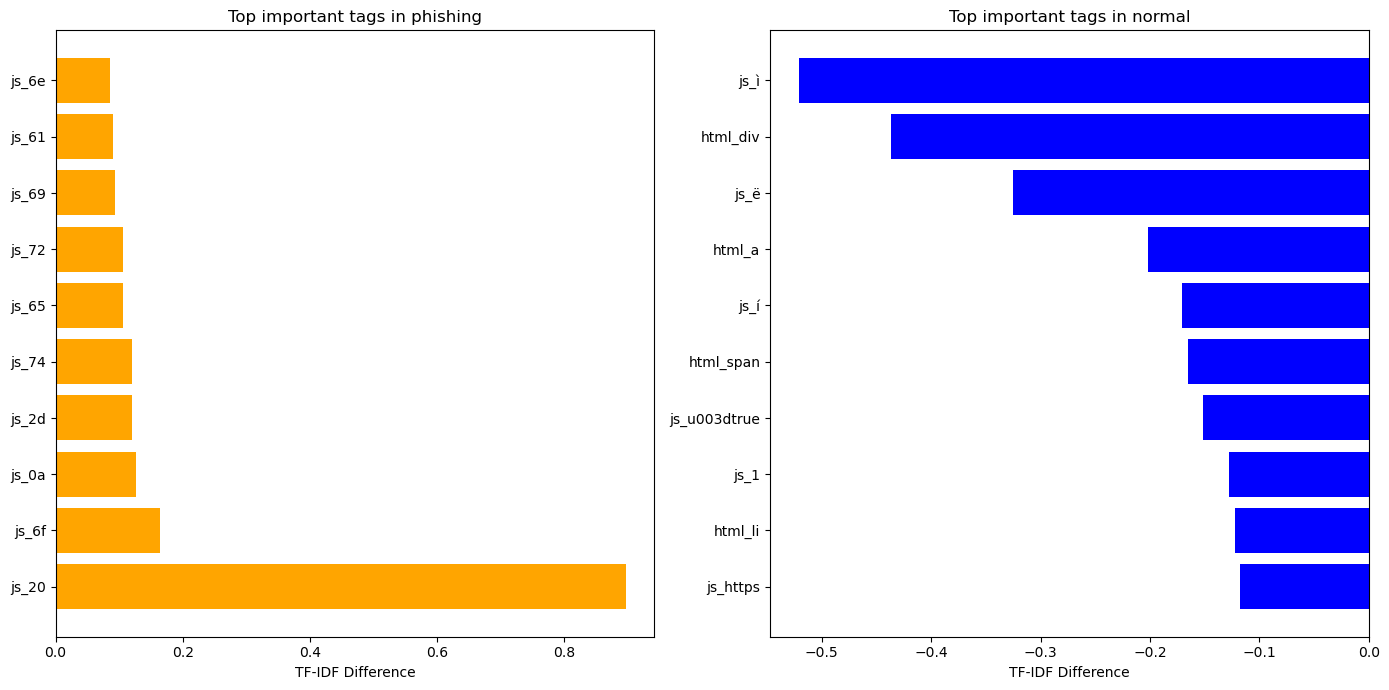

In [102]:
# 그래프로 시각화
top_positive_tags = tfidf_diff.head(10)
top_negative_tags = tfidf_diff.tail(10)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(top_positive_tags.index, top_positive_tags.values, color='orange')
plt.xlabel('TF-IDF Difference')
plt.title('Top important tags in phishing')

plt.subplot(1, 2, 2)
plt.barh(top_negative_tags.index, top_negative_tags.values, color='blue')
plt.xlabel('TF-IDF Difference')
plt.title('Top important tags in normal')

plt.tight_layout()
plt.show()

### 1. TF-IDF 분석을 통해 정상 사이트와 피싱 사이트에서 자주 나타나는 코드를 분석해 본 결과 영향력 있는 tag와 코드는 존재하지 않았다.
### 2. 그 차이를 계산하여 가장 큰 차이 10개를 본 결과 의미 없는 숫자와 문자가 나온 것을 미루어 보았을 때 HTML tag와 Javascript code에서는 각 URL마다의 차이만 존재할 뿐 피싱 사이트의 특징을 찾아낼 수 없었다.
### 3. 피싱 사이트가 정상 사이트와 구별할 수 없도록 최대한 똑같게 만들기 때문이라고 예측한다.
<br>
<span style="color:red; font-size:24px;">결론: 정상 사이트와 피싱 사이트의 HTML tag와 JavaScript code간의 유의미한 차이는 없다.</span>

<span style="color:blue; font-size:24px;">활용 방안 1. 사이트의 UI/UX를 기반으로 분석하는 것이 아닌 추가적인 예측 및 보안 조치가 필요하다. 크롬 익스텐션에서 위의 5개의 특징으로 빠르게 예측하는 서비스를 제공할 수 있다. </span>

# 가설3. 피싱 사이트의 타겟이 되는 일부 유형의 사이트가 있다. 
## 3-1. 텍스트의 길이가 짧은 사이트가 타겟이 되기 쉽다.
## 3-2. 특정 웹사이트의 종류가 피싱 사이트의 타겟이 되기 쉽다.
---

### 3-1. 텍스트의 길이가 짧은 사이트가 타겟이 되기 쉽다.
#### 상대적으로 구현하기 쉽고 사람들을 속이기 쉽다는 판단하에 간단한 사이트가 피싱 사이트의 타겟이 된다는 가정으로 진행하였다.

In [72]:
# URL에서 텍스트 길이를 가져오는 함수
def get_text_length(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            text = soup.get_text()
            return len(text)
        else:
            return 0
    except requests.RequestException:
        return 0

normal_urls_df = pd.read_csv('sampled_normal_urls.csv')
normal_urls = normal_urls_df['URL'].tolist()
phishing_urls_df = pd.read_csv('sampled_phishing_urls.csv')
phishing_urls = phishing_urls_df['URL'].tolist()

# 정상 사이트&피싱 사이트 텍스트 길이 
normal_text_lengths = [get_text_length(url) for url in normal_urls]
normal_urls_df['text_length'] = normal_text_lengths
phishing_text_lengths = [get_text_length(url) for url in phishing_urls]
phishing_urls_df['text_length'] = phishing_text_lengths

print(normal_urls_df.head())
print(phishing_urls_df.head())

                                                 URL  text_length
0  https://www.chosun.com/entertainments/broadcas...           39
1  https://www.chosun.com/national/national_gener...           37
2  https://www.inven.co.kr/webzine/news/?news=295...        13642
3                       https://www.arca.live#bottom        12472
4           https://www.youtube.com/about/copyright/        22005
                                      URL  text_length
0            https://hlgtde.hiplimit.top/         3079
1                   https://kl7777cp.com/            0
2  https://lh14.pages.dev/appeal_case_ID/        11943
3   https://check-valuation-r.vercel.app/          252
4  https://uch.mrn.mybluehost.me/MS/DHLM/            0


## 귀무가설 : 정상 웹사이트와 피싱 웹사이트의 평균 텍스트 길이에 차이가 없다. 
## 대립가설 : 정상 웹사이트의 평균 텍스트 길이가 피싱 웹사이트의 평균 텍스트 길이보다 길다.

In [77]:
from scipy import stats
#텍스트를 크롤링 하지 못한 값은 정확하지 못한 결과를 도출한다고 판단하여 제거
normal_urls_df = normal_urls_df[normal_urls_df['text_length'] > 0]
phishing_urls_df = phishing_urls_df[phishing_urls_df['text_length'] > 0]
print(normal_urls_df.describe())
print(phishing_urls_df.describe())

normal_text_lengths = normal_urls_df['text_length']
phishing_text_lengths = phishing_urls_df['text_length']

print(' ')
print("t-test result")

# t-test 수행
# 단순한(텍스트 길이가 짧은) 사이트가 피싱의 대상이 될 확률이 높다는 결과를 도출하여 insight를 얻기 위해 alternative를 greater로 설정
t_stat, p_value = stats.ttest_ind(normal_text_lengths, phishing_text_lengths, alternative = 'greater')

print(f"T-statistic: {t_stat}, P-value: {p_value}")

        text_length
count    473.000000
mean    6260.331924
std     9463.871711
min        4.000000
25%      722.000000
50%     3262.000000
75%     7178.000000
max    91302.000000
        text_length
count    419.000000
mean    1933.238663
std     5452.506795
min        1.000000
25%       62.000000
50%      371.000000
75%     2173.000000
max    74039.000000
 
t-test result
T-statistic: 8.227086332803847, P-value: 3.3864478355569497e-16


#### 다음 결과를 보면 귀무가설을 기각하고 대립가설을 채택한다. 정상 웹사이트와 피싱 웹사이트 간의 평균 텍스트 길이에 통계적으로 유의미한 차이가 있음을 보여준다.  
<br>
<span style="color:red; font-size:24px;">결론 : 피싱 사이트가 정상 웹사이트보다 평균적으로 텍스트 길이가 짧은 것으로 보아 텍스트 길이가 짧은 사이트는 피싱의 대상이 되지 않도록 유의해야한다.</span>
<br>

<span style="color:blue; font-size:24px;">활용 방안 1. simple한 UI/UX를 제공하기 위해 단순하게 사이트를 제공하는 경우 피싱 사이트가 되지 않도록 보안을 강화하는 등의 조치가 필요하다.</span>
<br>

<span style="color:blue; font-size:24px;">활용 방안 2. 사용자는 본인이 처음 접하는 사이트에서 단순하거나 길이가 짧은 웹 사이트에서 주의하여 사용하도록 한다.</span>

## 피싱 사이트의 텍스트를 통해 피싱 사이트의 주요 타겟이 되는 종류를 알아본다.
#### 모든 웹사이트의 유형을 알 수 없으니 텍스트 feature를 사용하여 비슷한 텍스트를 가진다면 같은 유형으로 판단한다.
#### 여기서는 인기 있는 웹사이트 종류 9가지(쇼핑몰 및 이커머스, 비즈니스, 블로그, 이력서 및 포트폴리오, 이벤트, 게시판, 회원제, 비영리)라는 정보를 기반으로 9개의 cluster로 나눈다. 

In [90]:
from sklearn.cluster import KMeans

def get_text_content(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            text = soup.get_text()
            return text
        else:
            return ""
    except requests.RequestException:
        return ""


normal_urls_df = pd.read_csv('sampled_normal_urls.csv')
phishing_urls_df = pd.read_csv('sampled_phishing_urls.csv')
normal_urls = normal_urls_df['URL'].tolist()
phishing_urls = phishing_urls_df['URL'].tolist()

normal_texts = [get_text_content(url) for url in normal_urls]
phishing_texts = [get_text_content(url) for url in phishing_urls]

all_texts = normal_texts + phishing_texts
all_urls = normal_urls + phishing_urls
all_labels = ['normal'] * len(normal_texts) + ['phishing'] * len(phishing_texts)

cluster_df = pd.DataFrame({'URL': all_urls, 'text': all_texts, 'label': all_labels})

#TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])

C:\Users\king7\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


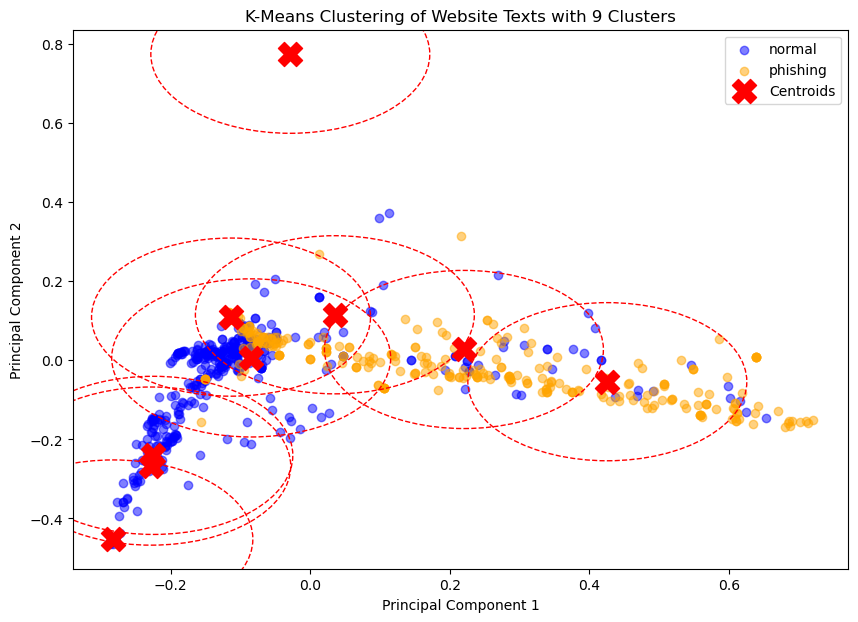

In [97]:
# K-Means 클러스터링
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(X)

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())
cluster_df['pc1'] = principal_components[:, 0]
cluster_df['pc2'] = principal_components[:, 1]

# 클러스터 중심 계산
cluster_centers = kmeans.cluster_centers_
cluster_centers_2d = pca.transform(cluster_centers)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
label_colors = {'normal': 'blue', 'phishing': 'orange'}

for label in cluster_df['label'].unique():
    cluster_data = cluster_df[cluster_df['label'] == label]
    plt.scatter(cluster_data['pc1'], cluster_data['pc2'], label=label, c=label_colors[label], alpha=0.5)

plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], s=300, c='red', label='Centroids', marker='X')
for center in cluster_centers_2d:
    circle = plt.Circle(center, 0.2, color='r', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Website Texts with 9 Clusters')
plt.legend()
plt.show()

### 1. 일부 클러스터에는 주로 피싱 웹사이트가 포함되어 있다. 이는 피싱 웹사이트가 특정한 유형의 텍스트 특성을 가질 가능성이 높음을 나타낸다. 하지만, PCA를 통해 feature 차원을 축소하여 정확한 특징을 알아내기 어렵다는 한계점을 지닌다.
### 2. 클러스터가 전체적으로 잘 분포되어 있다. 일부 클러스터는 피싱 웹사이트와 정상 웹사이트가 혼합되어 있으며, 이는 이 두 유형의 웹사이트가 텍스트 특성에서 유사점을 공유할 수 있음을 시사한다.

### 3. 특정 클러스터는 주로 피싱 웹사이트 또는 정상 웹사이트로만 구성되어 있어 특정 유형의 웹사이트가 특정 텍스트 특성을 강하게 공유하고 있음을 알 수 있다. 이 점으로부터 특정 텍스트를 가진 사이트는 피싱의 대상이 되지 않는다는 것을 추측할 수 있다.
<br>
<span style="color:red; font-size:24px;">결론 : 특정 텍스트 유형을 가진 사이트가 피싱의 대상이 된다.</span>

<br>

<span style="color:blue; font-size:24px;">활용 방안 1. 텍스트 기반으로 특정 유형의 사이트가 피싱의 대상이 된다는 것을 파악하였으므로 추가적인 연구를 통해 어떤 유형이 피싱의 대상이 되는지 파악하는데 사용한다.</span>
<br>

<span style="color:blue; font-size:24px;">활용 방안 2. 피싱의 대상이 되지 않는 클러스터들과 피싱의 대상이 되는 cluster 간의 보안 측면에서 차이를 비교하는 연구에 사용한다.</span>